# Fake News Detection with RNN

> Ming Zhao
> 
> Dec, 2023

The goal of this project is to detect fake news based on Recurrent Neural Networks (RNN).

### Contents

1. Import Libraries and Datasets    
2. Perform Exploratory Data Analysis (EDA)      
3. Perform Data Cleaning   
4. Visualize Data
5. Prepare Data: Tokenization and Padding
6. Understand RNN and LSTM
7. Build and Train the Model
8. Assess Model Performance
   
<br>

## 1. Import Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme, showing x and y axes clearly  

In [2]:
# load data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

## 2. Perform EDA

In [3]:
# add a target class column to indicate whether the news is real or fake
## true:1
## fake:0
df_true['isfake'] = 1
df_fake['isfake'] = 0

In [4]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [5]:
df.drop(columns = ['date'], inplace = True)

In [6]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


## 3. Perform Data Cleaning

In [7]:
# download stopwords
# nltk.download("stopwords")

In [8]:
# obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
# remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)            
    return result

In [10]:
# apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [11]:
# show original news
df['original'][0][:500]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which la'

In [12]:
# show cleaned news after removing stopwords
print(df['clean'][0][0:50])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday']


In [13]:
df.head()

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [14]:
# obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [15]:
print(list_of_words[:50])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday']


In [16]:
# obtain the total number of words
len(list_of_words)

9276947

In [17]:
# obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [18]:
df.head()

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [19]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [20]:
df.head()

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


## 4. Visualize Data

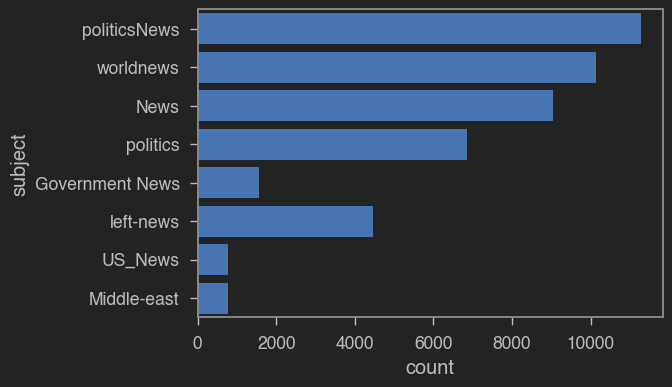

In [21]:
# plot the number of samples in 'subject'
plt.figure(figsize = (6, 4))
sns.countplot(y = "subject", data = df)
plt.show()

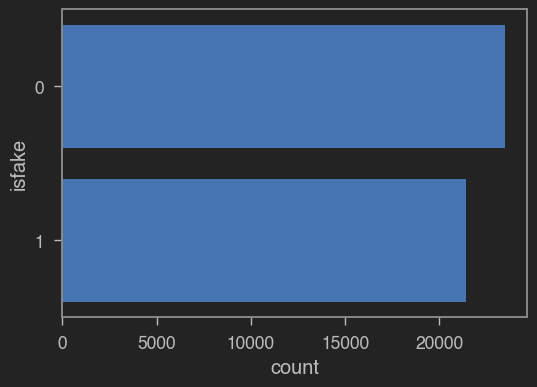

In [22]:
# plot the number of samples in 'isfake'
plt.figure(figsize = (6, 4))
sns.countplot(y = "isfake", data = df)
plt.show()

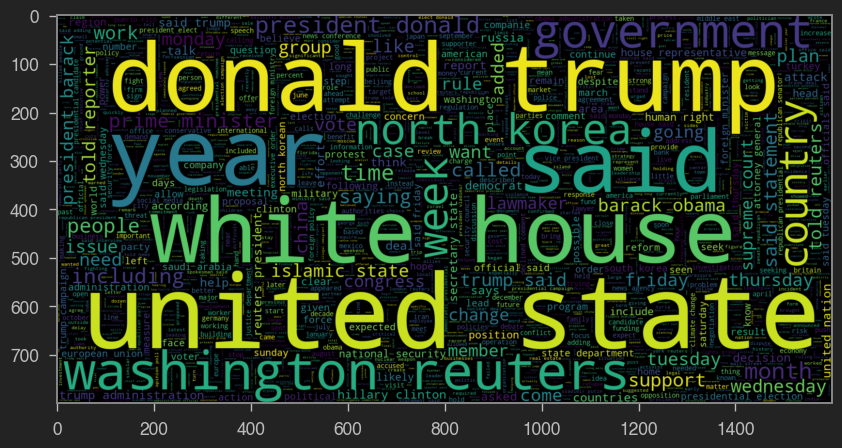

In [23]:
# plot the word cloud for text that is Real
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , 
               stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
## combine df[df.isfake == 1].clean_joined for every observation
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

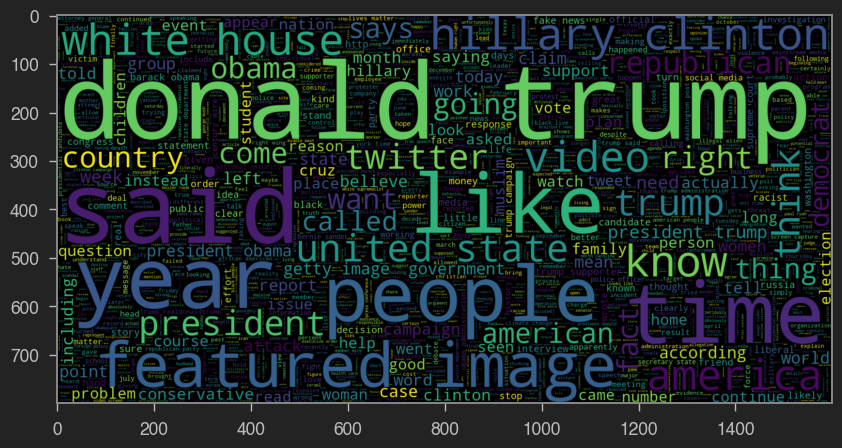

In [24]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , 
               stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [25]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


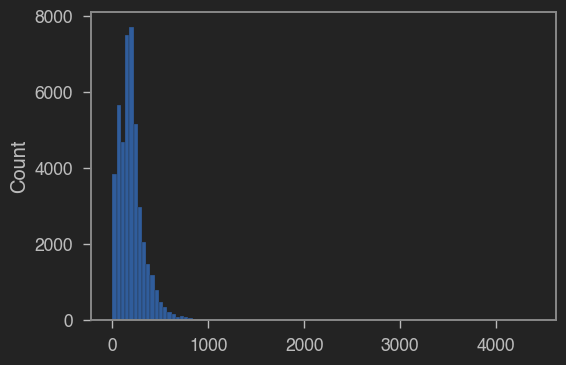

In [26]:
# visualize the distribution of number of words in a document
plt.figure(figsize = (6, 4))
sns.histplot(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], bins=100)
plt.show()

## 5. Prepare Data: Tokenization and Padding

**Tokenizer** allows us to vectorize text corpus by turning each text into a sequence of integers.
- sentence: "budget fight looms republicans flip fiscal script Washington Reuters head conservative republican faction congress voted month ..."
- tokens: [3138, 3581, 2895, 27, 5354, 22457, 3505, 9, 3138, 35, 2895, 208, 213, 3581, 29, 71,
5354, 22457, 1275, 335, 2, 619, 2903, 27, 10461, 43213, 4908, ...]


**Padding** is used to ensure that all sequences in a list have the same length.

In [27]:
# split data into test and train 
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2, random_state=23)

In [28]:
# create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [29]:
print("The encoding for document\n",df.clean_joined[0][:500],"\n is : \n",train_sequences[0][:500])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressiona 
 is : 
 [1734, 1617, 3677, 5945, 698, 154, 5870, 1122, 8, 1734, 426, 332, 519, 3677, 5945, 304, 2620, 154, 66, 76, 5378, 9271, 2, 86, 27418, 1298, 629, 7557, 95, 236, 2601, 698, 241, 531, 243, 76, 2342, 476, 973, 1003, 4427, 5870, 622, 1559, 1586, 758, 1734, 23, 13436, 11, 7731, 2756, 52, 1256, 5294, 53, 308, 154, 811, 1734, 176, 7772, 698, 241, 998, 332, 320, 130, 666, 255, 14, 698, 815, 95, 559, 513, 531, 11, 25136, 531, 799, 7732, 8958, 3808, 698, 815, 95, 505, 36

In [30]:
# add a limit length on the end of sequences
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, padding = 'post', truncating = 'post') 
## padding can either be maxlen = 4405 or smaller
## number maxlen = 40 seems to work well based on results
## truncating = 'post': remove values from sequences larger than maxlen at the end of the sequences

In [31]:
for i, doc in enumerate(padded_train[4:6]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [32551   331  1137     1    74 21904  2403   471     3   529  5349   182
  6610   132  1169  5705 65514  6610  2266   163  6610   306 65515   306
   221  1455     1 13266   275   388  1408     0     0     0     0     0
     0     0     0     0]
The padded encoding for document 2  is :  [3561    1   38 1491   77 2004  231 4575  625    3   10    1   38 1150
  303 2078    8 5278  794  303 1863 1491  375 4087 1602 1493  216  409
 1128  260   33   80 3187   18   23   77  242   92  958  894]


## 6. Understand RNN and LSTM

**RNN**
- RNN contains a temporal loop in which the hidden layer not only gives an output but it feeds itself as well.
- An extra added dimension is time.
- RNN can recall what happened in the previous time stamp so it works great with sequence of text.
- Why special?
    - CNN will have fixed size imange (28x28) and generate a fixed output (class or probabilities)
    - RNN allows to work with a sequence of vectors:
        - many to many (application: language translation)
        - one to many (application: image captioning)
        - many to one (application: sentiment analysis)

**LSTM**
- Long Short-Term Memory networks are a modified version of RNN that are designed to remember long term dependencies.
- LSTM can remember and recall information for a prolonged period of time.
- LSTM overcomes the vanishing gradient problem of RNN.
    - As the gradient goes smaller, the network weights are no longer updated.
    - As more layers are added, the gradients of the loss function approaches zero, making the network hard to train.

## 7. Build and Train the Model

**Embedding Layers** learn the low-dimensional continuous representation of input discrete variables.
- For example, embedding layer learns the way to represent 100,000 variables with 200 variables.

In [32]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14210305 (54.21 MB)
Trainable params: 14210305 (54.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
total_words

108704

In [34]:
y_train = np.asarray(y_train)

In [35]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 32s 60ms/step - loss: 0.0394 - acc: 0.9823 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 2/2
506/506 [==============================] - 30s 60ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0249 - val_acc: 0.9958


## 8. Assess Model Performance

In [36]:
# make prediction
pred = model.predict(padded_test)

281/281 [==============================] - 3s 10ms/step


In [37]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [38]:
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9953229398663697


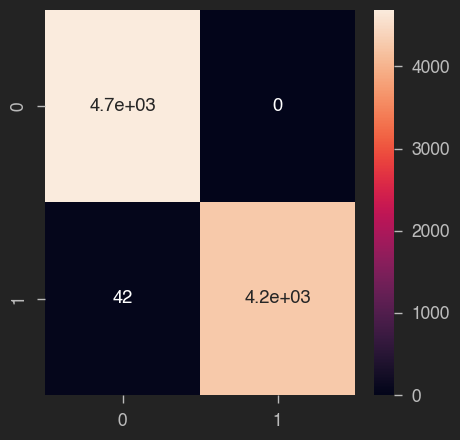

In [39]:
# get the confusion matrix
cm = confusion_matrix(list(y_test), prediction)

plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True)
plt.show()

In [40]:
# category = { 0: 'Fake News', 1 : "Real News"}

In [42]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print(f"True negative: {tn}" )
print(f"False positive: {fp}")
print(f"False negative: {fn}")
print(f"True positive: {tp}")

True negative: 4688
False positive: 0
False negative: 42
True positive: 4250


In [43]:
# evaluation function for accuracy, precision, recall
def cal_evaluation(classifier, conf_matrix):
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    tp = conf_matrix[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print ()
    print (classifier)
    print ("Accuracy is: " + str(accuracy.round(3)))
    print ("precision is: " + str(precision.round(3)))
    print ("recall is: " + str(recall.round(3)))

In [44]:
cal_evaluation("LSTM", cm)


LSTM
Accuracy is: 0.995
precision is: 1.0
recall is: 0.99
